# How to Train YOLOv7 on a Custom Dataset

This tutorial is based on the [YOLOv7 repository](https://github.com/WongKinYiu/yolov7) by WongKinYiu. This notebook shows training on **your own custom objects**. Many thanks to WongKinYiu and AlexeyAB for putting this repository together.


### **Accompanying Blog Post**

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv7](https://blog.roboflow.com/yolov7-custom-dataset-training-tutorial/), concurrently.

### **Steps Covered in this Tutorial**

To train our detector we take the following steps:

* Install YOLOv7 dependencies
* Load custom dataset from Roboflow in YOLOv7 format
* Run YOLOv7 training
* Evaluate YOLOv7 performance
* Run YOLOv7 inference on test images
* OPTIONAL: Deployment
* OPTIONAL: Active Learning


### Preparing a Custom Dataset

In this tutorial, we will utilize an open source computer vision dataset from one of the 90,000+ available on [Roboflow Universe](https://universe.roboflow.com).

If you already have your own images (and, optionally, annotations), you can convert your dataset using [Roboflow](https://roboflow.com), a set of tools developers use to build better computer vision models quickly and accurately. 100k+ developers use roboflow for (automatic) annotation, converting dataset formats (like to YOLOv7), training, deploying, and improving their datasets/models.

Follow [the getting started guide here](https://docs.roboflow.com/quick-start) to create and prepare your own custom dataset.

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
!nvidia-smi

In [ ]:
# Download YOLOv7 repository and install requirements

# !git clone https://github.com/WongKinYiu/yolov7
# %cd yolov7
# !pip install -r requirements.txt

# current version of YOLOv7 is not compatible with pytorch>1.12.1 and numpy>1.20.1
# until the appropriate changes get made to the main repository, we will be using a fork containing the patched code
# you can track the progress here: https://github.com/roboflow/notebooks/issues/27
!git clone https://github.com/SkalskiP/yolov7.git
%cd yolov7
!git checkout fix/problems_associated_with_the_latest_versions_of_pytorch_and_numpy
!pip install -r requirements.txt

# Download Correctly Formatted Custom Data

Next, we'll download our dataset in the right format. Use the `YOLOv7 PyTorch` export. Note that this model requires YOLO TXT annotations, a custom YAML file, and organized directories. The roboflow export writes this for us and saves it in the correct spot.


In [ ]:
# REPLACE with your custom code snippet generated above

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR API KEY")
project = rf.workspace("YOUR-WORKSPACE").project("YOUR-PROJECT")
dataset = project.version(1).download("yolov7")

# Begin Custom Training

We're ready to start custom training.

NOTE: We will only modify one of the YOLOv7 training defaults in our example: `epochs`. We will adjust from 300 to 100 epochs in our example for speed. If you'd like to change other settings, see details in [our accompanying blog post](https://blog.roboflow.com/yolov7-custom-dataset-training-tutorial/).

In [ ]:
# download COCO starting checkpoint
%cd /content/yolov7
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

In [ ]:
# run this cell to begin training
%cd /content/yolov7
!python train.py --batch 16 --epochs 55 --data {dataset.location}/data.yaml --weights 'yolov7_training.pt' --device 0 


# Evaluation

We can evaluate the performance of our custom training using the provided evalution script.

Note we can adjust the below custom arguments. For details, see [the arguments accepted by detect.py](https://github.com/WongKinYiu/yolov7/blob/main/detect.py#L154).

In [ ]:
# Run evaluation
!python detect.py --weights runs/train/exp/weights/best.pt --conf 0.1 --source {dataset.location}/test/images


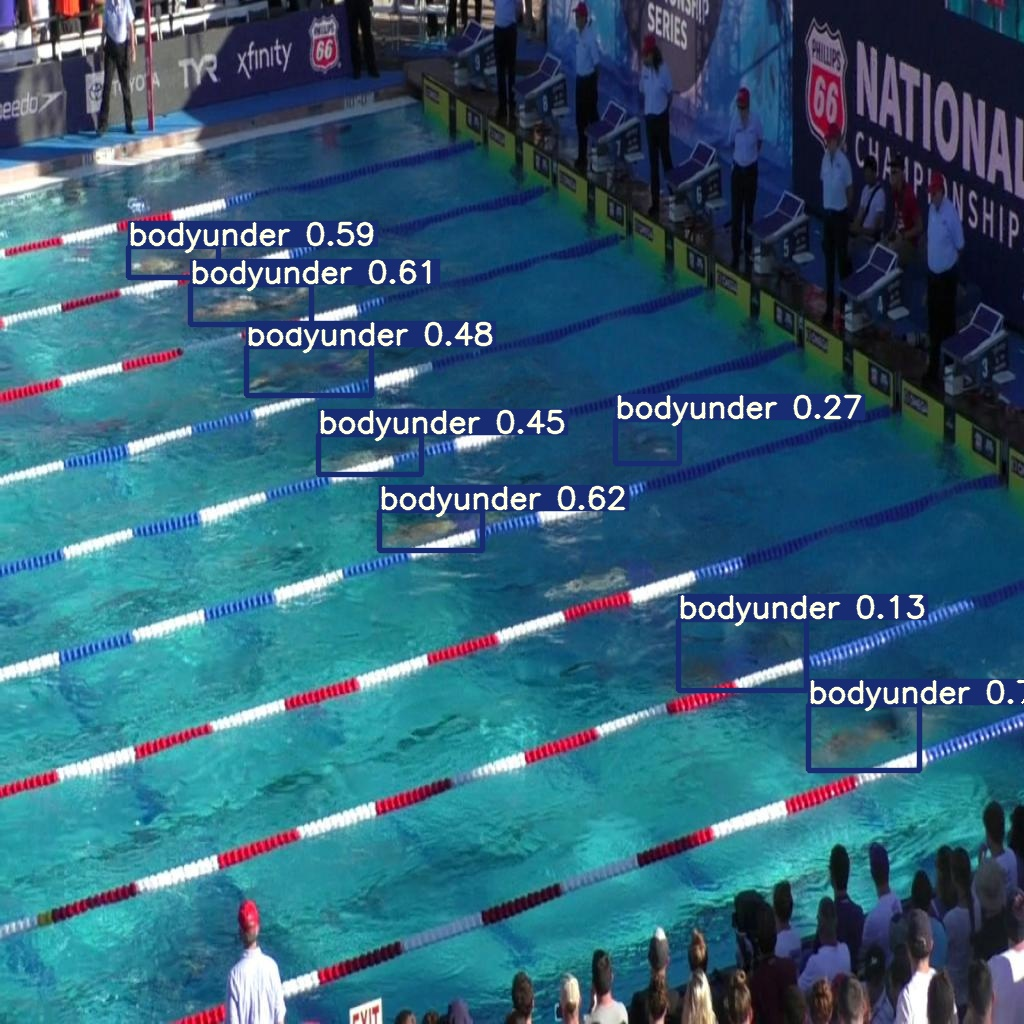

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
for imageName in glob.glob('/content/yolov7/runs/detect/exp/*.jpg'): #assuming JPG
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1
    

# Reparameterize for Inference

https://github.com/WongKinYiu/yolov7/blob/main/tools/reparameterization.ipynb

# OPTIONAL: Deployment

To deploy, you'll need to export your weights and save them to use later.

In [ ]:
# optional, zip to download weights and results locally

!zip -r export.zip runs/detect
!zip -r export.zip runs/train/exp/weights/best.pt
!zip export.zip runs/train/exp/*

# OPTIONAL: Active Learning Example

Once our first training run is complete, we should use our model to help identify which images are most problematic in order to investigate, annotate, and improve our dataset (and, therefore, model).

To do that, we can execute code that automatically uploads images back to our hosted dataset if the image is a specific class or below a given confidence threshold.


In [ ]:
# # setup access to your workspace
# rf = Roboflow(api_key="YOUR_API_KEY")                               # used above to load data
# inference_project =  rf.workspace().project("YOUR_PROJECT_NAME")    # used above to load data
# model = inference_project.version(1).model

# upload_project = rf.workspace().project("YOUR_PROJECT_NAME")

# print("inference reference point: ", inference_project)
# print("upload destination: ", upload_project)

In [ ]:
# # example upload: if prediction is below a given confidence threshold, upload it 

# confidence_interval = [10,70]                                   # [lower_bound_percent, upper_bound_percent]

# for prediction in predictions:                                  # predictions list to loop through
#   if(prediction['confidence'] * 100 >= confidence_interval[0] and 
#           prediction['confidence'] * 100 <= confidence_interval[1]):
        
#           # upload on success!
#           print(' >> image uploaded!')
#           upload_project.upload(image, num_retry_uploads=3)     # upload image in question

# Next steps

Congratulations, you've trained a custom YOLOv7 model! Next, start thinking about deploying and [building an MLOps pipeline](https://docs.roboflow.com) so your model gets better the more data it sees in the wild.